# Building Blocks
## The important pieces to analyze (a lot of) data

# RDD - Resiliant Distributed Dataset
Spark's basic data collection is an RDD:
* *Resiliant* - Any piece that is lost can be regenerated
* *Distributed* - Pieces are scattered across multiple nodes
* *Dataset* - A large number of "items" either generated from files or by translating other RDDs

No restriction that each "item" in an RDD have the same elements, somewhat low-level for many uses

# DataFrame
DataFrames are specialized RDDs that organize their data in rows and columns, where every row has the same columns. This is similar to CMS datasets where each event in Data/MC has the same branches.

The layout of a DataFrame is more limited than a plain RDD, but this limitation allows Spark's query optimizer to speed up or even elide portions of results.

# Outline
The tools are different, but the overall workflow is familiar:

1. Import datasets from disk
2. Apply transformations
  * Perform cuts
  * Produce derived values
3. Aggregate and report to produce tables/plots

Let's first demonstrate the tools and concepts with a small, non-CMS dataset.

For our first example, we will use the US Government's records of all flights in the US during 2015 (found [here](http://stat-computing.org/dataexpo/)). It's a small dataset that Spark is ridiculously overpowered for, but its size lets us experiment instantaneously. 

## Setup
Before we do anything with Spark, we must create a `SparkSession` like you did in the pre-exercise.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
spark = SparkSession.builder \
            .appName("10-airline-data") \
            .config("spark.jars.packages", "org.diana-hep:histogrammar-sparksql_2.11:1.0.4") \
            .getOrCreate()

In [2]:
csvPath = "hdfs://cmshdfs/tmp/2005.csv.bz2"
airline = spark.read \
            .option("header","true") \
            .option("inferSchema", "true") \
            .csv(csvPath) \
            .sort("Month", "DayofMonth") \
            .withColumnRenamed("UniqueCarrier", "Carrier")

In [3]:
airline.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Carrie

In [4]:
airline = airline.withColumn("DepTime", airline["DepTime"].cast(IntegerType()))\
                    .withColumn("ArrTime", airline["ArrTime"].cast(IntegerType()))\
                    .withColumn("DepDelay", airline["DepDelay"].cast(IntegerType()))\
                    .withColumn("ArrDelay", airline["ArrDelay"].cast(IntegerType()))

In [5]:
airline.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- Carrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Ca

In [6]:
airline.take(1)

[Row(Year=2005, Month=1, DayofMonth=1, DayOfWeek=6, DepTime=1704, CRSDepTime=1715, ArrTime=1919, CRSArrTime=1915, Carrier='UA', FlightNum=543, TailNum='N203UA', ActualElapsedTime='195', CRSElapsedTime=180, AirTime='144', ArrDelay=4, DepDelay=-11, Origin='BOS', Dest='ORD', Distance=867, TaxiIn=13, TaxiOut=38, Cancelled=0, CancellationCode=None, Diverted=0, CarrierDelay=0, WeatherDelay=0, NASDelay=0, SecurityDelay=0, LateAircraftDelay=0)]

In [7]:
airline.show(1)

+----+-----+----------+---------+-------+----------+-------+----------+-------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|Carrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2005|    1|         1|        6|   1600|      1605|   1747|      1800|     XE|     2450| N12567|              1

In [8]:
# https://spark.apache.org/docs/2.2.0/api/python/pyspark.sql.html?highlight=cache#pyspark.sql.DataFrame.drop
airline = airline.drop("CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay")
airline.show(1)

+----+-----+----------+---------+-------+----------+-------+----------+-------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|Carrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+-----------------+
|2005|    1|         1|        6|   1600|      1605|   1747|      1800|     XE|     2450| N12567|              107|           115|     89|     -13|      -5|   EWR| DAY|     533|     3|     15|        0|            null|       0|                0|
+----+-----+

In [9]:
trimmedAirline = airline.select("Month", "DayOfMonth", "DayOfWeek",
                                "DepTime", "ArrDelay", "DepDelay",
                                "TaxiIn", "TaxiOut", "Origin",
                                "Dest", "Distance", "Carrier",
                                "FlightNum", "Cancelled")

In [10]:
trimmedAirline.show(5)

+-----+----------+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|Month|DayOfMonth|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|
+-----+----------+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|    1|         1|        6|   1600|     -13|      -5|     3|     15|   EWR| DAY|     533|     XE|     2450|        0|
|    1|         1|        6|   1627|      -9|      -3|     5|     26|   IAH| CLT|     913|     XE|     2810|        0|
|    1|         1|        6|    711|       5|      11|     5|     16|   ATL| IAH|     689|     XE|     2940|        0|
|    1|         1|        6|   1206|       2|      -4|     7|     19|   IND| IAH|     845|     XE|     2867|        0|
|    1|         1|        6|    918|      -7|      -7|     4|     22|   CLE| MSY|     917|     XE|     2432|        0|
+-----+----------+---------+-------+--------+---

In [11]:
# Do some filtering
trimmedAirline.where(trimmedAirline.Carrier != "UA").show(5)

+-----+----------+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|Month|DayOfMonth|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|
+-----+----------+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|    1|         1|        6|   1600|     -13|      -5|     3|     15|   EWR| DAY|     533|     XE|     2450|        0|
|    1|         1|        6|   1627|      -9|      -3|     5|     26|   IAH| CLT|     913|     XE|     2810|        0|
|    1|         1|        6|    711|       5|      11|     5|     16|   ATL| IAH|     689|     XE|     2940|        0|
|    1|         1|        6|   1206|       2|      -4|     7|     19|   IND| IAH|     845|     XE|     2867|        0|
|    1|         1|        6|    918|      -7|      -7|     4|     22|   CLE| MSY|     917|     XE|     2432|        0|
+-----+----------+---------+-------+--------+---

# What about a more complicated expression?
```python
trimmedAirline.where(trimmedAirline.Month == 1 and trimmedAirline.DayOfMonth == 8).show(5)
```

In [12]:
trimmedAirline.where(trimmedAirline.Month == 1 and trimmedAirline.DayOfMonth == 8).show(5)

ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

uh oh..
```
ValueError: Cannot convert column into bool: please use '&' for 'and'
```
Let's try that....
```python
trimmedAirline.where(trimmedAirline.Month == 1 & trimmedAirline.DayOfMonth == 8).show(5)
```

In [13]:
trimmedAirline.where(trimmedAirline.Month == 1 & trimmedAirline.DayOfMonth == 8).show(5)

Py4JError: An error occurred while calling o136.and. Trace:
py4j.Py4JException: Method and([class java.lang.Integer]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:318)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:326)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)



The previous cell complains:
```
Method and([class java.lang.Integer]) does not exist
```
The "&" operator has weird operator precidence, so the previous line:
```python
trimmedAirline.where(trimmedAirline.Month == 1 & trimmedAirline.DayOfMonth == 8).show(5)
```
Is interpreted as
```python
trimmedAirline.where(trimmedAirline.Month == (1 & trimmedAirline.DayOfMonth) == 8).show(5)
```
Add explicit parenthesis to force what we really mean:
```python
trimmedAirline.where((trimmedAirline.Month == 1) & (trimmedAirline.DayOfMonth == 8)).show(5)
```

In [14]:
trimmedAirline.where((trimmedAirline.Month == 1) & (trimmedAirline.DayOfMonth == 8)).show(5)

+-----+----------+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|Month|DayOfMonth|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|
+-----+----------+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|    1|         8|        6|   1453|      20|      23|    10|     20|   EWR| DTW|     487|     CO|      877|        0|
|    1|         8|        6|   1528|      12|       8|     5|     34|   EWR| MCO|     938|     CO|      392|        0|
|    1|         8|        6|   1807|      16|      -3|     3|     29|   CLE| MCO|     895|     CO|     1513|        0|
|    1|         8|        6|   1915|      43|      55|     5|     13|   IAH| MCO|     853|     CO|     1286|        0|
|    1|         8|        6|   1222|       1|      17|     8|     11|   TPA| EWR|     998|     CO|      858|        0|
+-----+----------+---------+-------+--------+---

# "SQL string" format
This is a lot easier for complicated expressions
```python
trimmedAirline.where("Month == 1 and DayOfMonth == 8").show(5)
```

In [15]:
trimmedAirline.where("Month == 1 and DayOfMonth == 8").show(5)

+-----+----------+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|Month|DayOfMonth|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|
+-----+----------+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|    1|         8|        6|    703|       3|      -2|    24|      8|   CMH| EWR|     462|     XE|     2858|        0|
|    1|         8|        6|   1001|     -29|      -9|     7|     12|   BNA| EWR|     748|     XE|     2530|        0|
|    1|         8|        6|   1433|     -11|      -2|     3|     19|   EWR| PVD|     160|     XE|     2956|        0|
|    1|         8|        6|   1422|      12|      -8|     7|     16|   JAX| EWR|     821|     XE|     3208|        0|
|    1|         8|        6|    616|      23|      -4|     6|     40|   BNA| IAH|     657|     XE|     2831|        0|
+-----+----------+---------+-------+--------+---

In [16]:
trimmedAirline.where("Month == 1 and Origin == 'ORD' and Dest == 'EWR'").count()

621

In [17]:
trimmedAirline.where("Month == 1 and DayOfMonth == 9 and Origin == 'ORD' and Dest == 'EWR'").count()

17

In [18]:
trimmedAirline.where("""Month == 1 AND DayOfMonth == 9 AND 
                        ((Origin == 'ORD' AND Dest == 'EWR') OR
                         (Origin == 'EWR' AND Dest == 'ORD'))""").count()

37

# Rename columns

In [19]:
renamed = trimmedAirline.withColumnRenamed("DayOfMonth", "Day")
renamed.show()

+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|Month|Day|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|
+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+
|    1|  1|        6|   1317|       3|      10|    13|     23|   IAH| ORD|     925|     CO|      146|        0|
|    1|  1|        6|   1032|     -10|      -1|     5|     16|   IAH| DEN|     861|     CO|      499|        0|
|    1|  1|        6|   1142|      -9|      -2|     8|     13|   DTW| IAH|    1076|     CO|     1589|        0|
|    1|  1|        6|   1213|      -7|      -2|     6|     12|   MDW| EWR|     711|     CO|     1145|        0|
|    1|  1|        6|   1202|      10|       2|     7|     25|   EWR| SEA|    2401|     CO|     1281|        0|
|    1|  1|        6|   1223|       4|      -2|     9|     25|   SAN| IAH|    1303|     CO|      374|   

## Produce derived values

In [20]:
# Add a simple column for "How much time was 'made up in the air'"
makeupTime = renamed.withColumn("Makeup", (renamed.ArrDelay - renamed.DepDelay).cast("integer"))
makeupTime.show(5)

+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+------+
|Month|Day|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|Makeup|
+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+------+
|    1|  1|        6|   1206|       2|      -4|     7|     19|   IND| IAH|     845|     XE|     2867|        0|     6|
|    1|  1|        6|    918|      -7|      -7|     4|     22|   CLE| MSY|     917|     XE|     2432|        0|     0|
|    1|  1|        6|   1627|      -9|      -3|     5|     26|   IAH| CLT|     913|     XE|     2810|        0|    -6|
|    1|  1|        6|    711|       5|      11|     5|     16|   ATL| IAH|     689|     XE|     2940|        0|    -6|
|    1|  1|        6|   1600|     -13|      -5|     3|     15|   EWR| DAY|     533|     XE|     2450|        0|    -8|
+-----+---+---------+-------+--------+--------+-

In [21]:
# What if we want something thats more complicated than just simple arithmetic?
# We can make a UDF - User Defined Function

# Spark will execute the following function for each row. You can put arbitrary python
# code here (with some restrictions)
import datetime
def dayOfYear(month, day):
    """
    Given a month and day, return the day of year.
        (e.g. Jan 1st is day "0")
    """
    return datetime.date(2005,month,day).timetuple()[7] - 1

from pyspark.sql.functions import udf
from pyspark.sql.types import *
dayUDF = udf(dayOfYear, IntegerType())

withDay = makeupTime.withColumn("DayCount", dayUDF("Month", "Day"))
withDay.show(5)

+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+------+--------+
|Month|Day|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|Makeup|DayCount|
+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+------+--------+
|    1|  1|        6|   1600|     -13|      -5|     3|     15|   EWR| DAY|     533|     XE|     2450|        0|    -8|       0|
|    1|  1|        6|   1627|      -9|      -3|     5|     26|   IAH| CLT|     913|     XE|     2810|        0|    -6|       0|
|    1|  1|        6|    711|       5|      11|     5|     16|   ATL| IAH|     689|     XE|     2940|        0|    -6|       0|
|    1|  1|        6|   1206|       2|      -4|     7|     19|   IND| IAH|     845|     XE|     2867|        0|     6|       0|
|    1|  1|        6|    918|      -7|      -7|     4|     22|   CLE| MSY|     917|     XE|     2432|   

In [22]:
# Suppose you wanted to correct Jet energies and make corresponding changes
# to the MET of the event. It would be difficult and inefficient to run two UDFs.
# Fortunately, we aren't limited to a single output column. We can pass back a
# structure to spark, and it will expand each memeber into a column

dateSchema = StructType([
    StructField("Date", DateType(), False),
    StructField("Count", IntegerType(), False),
])

def dateUDF(month, day):
    """
    Given a month and day, return the day of year and the 
        (e.g. Jan 1st is day "0")
    """
    dateObj = datetime.date(2005,month,day)
    dayCount = dateObj.timetuple()[7] - 1
    return (dateObj, dayCount)

from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
dayUDF = udf(dateUDF, dateSchema)

withDayNested = makeupTime.withColumn("udf2", dayUDF("Month", "Day"))
withDayNested.show(5)

+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+------+---------------+
|Month|Day|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|Makeup|           udf2|
+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+------+---------------+
|    1|  1|        6|   1303|      66|      58|     8|     15|   ORD| MSP|     334|     UA|      547|        0|     8|[2005-01-01, 0]|
|    1|  1|        6|    831|     -18|      -4|     7|     12|   MIA| ORD|    1197|     UA|      547|        0|   -14|[2005-01-01, 0]|
|    1|  1|        6|   1704|       4|     -11|    13|     38|   BOS| ORD|     867|     UA|      543|        0|    15|[2005-01-01, 0]|
|    1|  1|        6|   2342|     152|     147|     7|     20|   ORD| DAY|     240|     UA|      546|        0|     5|[2005-01-01, 0]|
|    1|  1|        6|   1345|       9|      18|     3| 

In [23]:
withDayFlat = withDayNested.select("udf2.Date", "udf2.Count")
withDayFlat.show(5)

+----------+-----+
|      Date|Count|
+----------+-----+
|2005-01-01|    0|
|2005-01-01|    0|
|2005-01-01|    0|
|2005-01-01|    0|
|2005-01-01|    0|
+----------+-----+
only showing top 5 rows



In [24]:
data = withDayNested \
                .withColumn("FlatDate", withDayNested.udf2.Date) \
                .withColumn("FlatCount", withDayNested.udf2.Count) \
                .drop(withDayNested.udf2)
data.show(5)

+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+------+----------+---------+
|Month|Day|DayOfWeek|DepTime|ArrDelay|DepDelay|TaxiIn|TaxiOut|Origin|Dest|Distance|Carrier|FlightNum|Cancelled|Makeup|  FlatDate|FlatCount|
+-----+---+---------+-------+--------+--------+------+-------+------+----+--------+-------+---------+---------+------+----------+---------+
|    1|  1|        6|   1600|     -13|      -5|     3|     15|   EWR| DAY|     533|     XE|     2450|        0|    -8|2005-01-01|        0|
|    1|  1|        6|   1627|      -9|      -3|     5|     26|   IAH| CLT|     913|     XE|     2810|        0|    -6|2005-01-01|        0|
|    1|  1|        6|    711|       5|      11|     5|     16|   ATL| IAH|     689|     XE|     2940|        0|    -6|2005-01-01|        0|
|    1|  1|        6|   1206|       2|      -4|     7|     19|   IND| IAH|     845|     XE|     2867|        0|     6|2005-01-01|        0|
|    1|  1|        6

# Aggregate and Report
Once we've loaded our data, done some filters and added some generated values, we'll want to aggregate the information so we can report values and/or make plots.

In [25]:
# How many flights are cancelled on each day of the week
days = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
cancelledPerDay = []
for i in range(len(days)):
    cancelledPerDay.append(data.where("DayOfWeek == %i and Cancelled == 1" % (i + 1)).count())

In [27]:
for i in zip(days, cancelledPerDay):
    print("%s: %i" % i)

Sun: 20277
Mon: 20381
Tue: 21698
Wed: 19600
Thu: 17352
Fri: 17084
Sat: 17338


### Load matplotlib and histogrammar
For simple queries, a combination of `select` and `count` are sufficient, but more advanced queries need additional packages. Run the following snippet in the next cell to load Matplotlib and Histogrammar

```python
%matplotlib inline
import matplotlib.pyplot as plt
import histogrammar as hg
import histogrammar.sparksql
```

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import histogrammar as hg
import histogrammar.sparksql

### Decorate our DataFrame
With Histogrammar loaded, we can make our DataFrame "Histogrammar-aware" by executing the following:
    
```python
    hg.sparksql.addMethods(data)
```

As you can probably guess, `addMethods` adds some magic methods to allow our Dataframe to be processed by Histogrammar

In [29]:
hg.sparksql.addMethods(data)

### Plot a single variable
At this point, we've got all the piece we need to actually extract some meaningful information from our dataset. Let's run the simplest-possible plotting in the next cell with:

```python
%%timeit -n3
h1 = data.Bin(100, 0, 200, data['ArrDelay'])
ax = h1.plot.matplotlib(name="Arrival Delay (min)")
```

The `%%timeit` magic command will execute the cell 3 times and report the best iteration

5.66 s ± 169 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


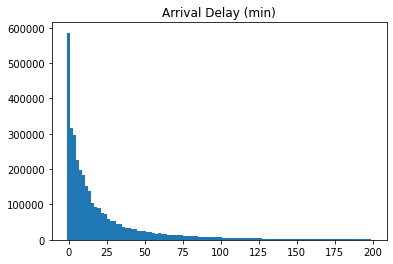

In [30]:
%%timeit -n3
h1 = data.Bin(100, 0, 200, data['ArrDelay'])
ax = h1.plot.matplotlib(name="Arrival Delay (min)")

### What just happened?
When the previous cell was executed, Spark did the following using several distributed workers:
1. Load the data from the CSV and divide into a number of `partitions`
2. Perform each transformation on the partitions
3. Histogrammar fills a histogram per-partition
4. Histogrammar uses Spark to perform a distributed reduce/aggregation
5. The resulting histogram is passed to Matplotlib to be plotted

### Why is this useful?
* Spark hides a lot of the complexity
    * Splitting tasks
    * Retrying failed jobs
* Spark can optimize away unwanted computation
* Spark can aggressively cache intermediate results
* Distributed reduces are fast!

# More examples
Now that we've plotted a single variable, let's do some more complicated aggregations and plots.

Let's make a histogram of the departure delay, following the template from before

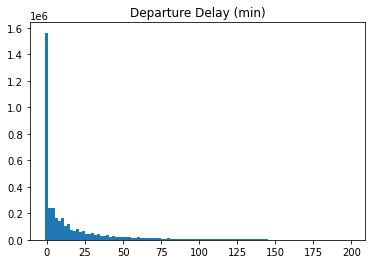

In [31]:
h2 = data.Bin(100, 0, 200, data['DepDelay'])
ax = h2.plot.matplotlib(name="Departure Delay (min)")

What we've effectively done in the two previous cells is make two histograms (`h1` and `h2`), then filled them independently. In the background, Spark performed two separate aggregations. Histogrammar instead lets us combine the histograms together and perform a single aggregation.

In [32]:
# Note only the outer UntypedLabel connects to data. The
# internal Bin objects connect to histogrammar. The outer
# container will pass the elements in
h3 = data.UntypedLabel(arrdelay=hg.Bin(100, 0, 200, data['ArrDelay']),
                       depdelay=hg.Bin(100, 0, 200, data['DepDelay']),)

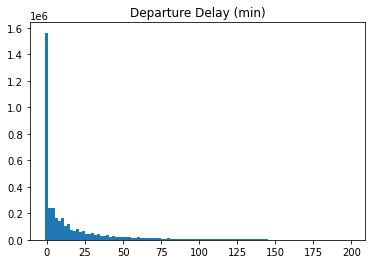

In [33]:
dd = h3.get('depdelay').plot.matplotlib(name="Departure Delay (min)")

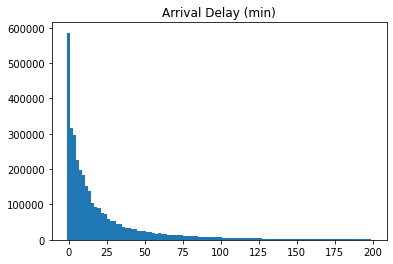

In [34]:
ad = h3.get('arrdelay').plot.matplotlib(name="Arrival Delay (min)")

## Multiple plots
It can be helpful to show multiple plots in a single cell

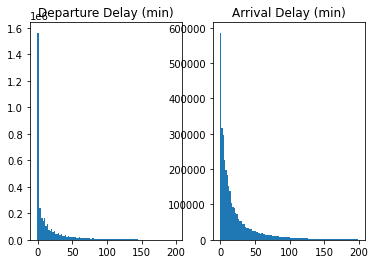

In [35]:
plt.subplot(1, 2, 1)
dd = h3.get('depdelay').plot.matplotlib(name="Departure Delay (min)")
plt.subplot(1, 2, 2)
ad = h3.get('arrdelay').plot.matplotlib(name="Arrival Delay (min)")

## 2D histograms
Implicit in the `Bin()` definition we've seen so far is the value we want to fill. By default, the value is filled by `Count()`, which effectively adds a one into the appropriate bin.
```python
h4 = data.Bin(100, 0, 200, data['DepDelay'], value=hg.Count())
```
We can make a 2D histogram by replacing `Count()` with a 1D histogram
```python
h4 = data.Bin(100, 0, 200, data['DepDelay'],
              value=hg.Bin(100, 0, 200, data['ArrDelay']))
```

## Selecting a subset of events
The `Select()` function lets us extract a subset of events
```python
h5 = data.UntypedLabel(
        ua=hg.Select(data['Carrier'] == "UA", 
                         hg.Bin(100, 0, 200, data['ArrDelay'])),
        aa=hg.Select(data['Carrier'] == "AA", 
                         hg.Bin(100, 0, 200, data['ArrDelay']))
    )
```

In [36]:
h5 = data.UntypedLabel(
        ua=hg.Select(data['Carrier'] == "UA", 
                         hg.Bin(100, 0, 200, data['ArrDelay'])),
        aa=hg.Select(data['Carrier'] == "AA", 
                         hg.Bin(100, 0, 200, data['ArrDelay']))
    )

## Plotting two histograms simultaneously
```python
plt.xlabel('Minutes Delayed')
h5.get('ua').plot.matplotlib(alpha=0.4, label='United')
h5.get('aa').plot.matplotlib(alpha=0.4, label='American')
plt.legend(loc='upper right')
plt.title('Delays by airline')
```

Text(0.5, 1.0, 'Delays by airline')

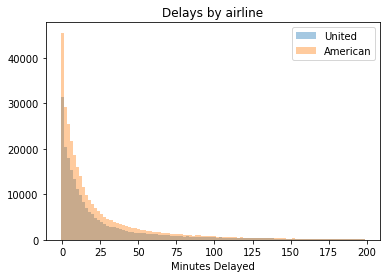

In [37]:
plt.xlabel('Minutes Delayed')
h5.get('ua').plot.matplotlib(alpha=0.4, label='United')
h5.get('aa').plot.matplotlib(alpha=0.4, label='American')
plt.legend(loc='upper right')
plt.title('Delays by airline')

## Other aggregation operators
Histogrammar provides a [number](http://histogrammar.org/python/1.0.9/) of additional aggregation operators. For instance, we can get the average arrival delay like the following.
```python
h6 = data.UntypedLabel(
        ua=hg.Select(data['Carrier'] == "UA", 
                         hg.Average(data['ArrDelay'])),
        aa=hg.Select(data['Carrier'] == "AA", 
                         hg.Average(data['ArrDelay']))
    )
print h6.get('ua').cut.mean
```                               

In [39]:
h6 = data.UntypedLabel(
        ua=hg.Select(data['Carrier'] == "UA", 
                         hg.Average(data['ArrDelay'])),
        aa=hg.Select(data['Carrier'] == "AA", 
                         hg.Average(data['ArrDelay']))
    )
print(h6.get('ua').cut.mean)

7.4487382644808395


# Your turn!
Before we move to a CMS dataset, use what you've learned so far to count the number of cancelled flights for each month. Do you notice anything odd?

# Other ideas
If you've got extra time, answer the following:
1. What are the 10 most popular routes?
2. What airports are the most delayed outbound? Inbound?
3. Show the trend of "mins made up" vs. distance.
4. What airline has the lowest average delay?

# Summary
We looked all US flights in 2005 and studied their on-time arrival statistics. We used Spark, Histogrammar, and Matplotlib to:
1. Import datasets from disk
2. Apply transformations
  * Perform cuts
  * Produce derived values
3. Aggregate and report to produce tables/plots

Next, we'll apply these lessons to CMS data.

# Don't forget to clean up!
Once you've completed this section and you're satisfied with the results, select "File->Close and Halt" from the Jupyter window. Spark is memory intensive, so it's good to remember to close the notebook when you're done. (Closing the notebook terminates the Spark process).